In [1]:
# LIBRERIAS
import matplotlib
from ipywidgets.widgets.widget_string import Label
from ipywidgets import interact,widgets
import numpy as np
import matplotlib.pylab as plt
from mpl_toolkits import mplot3d
import math
from scipy.integrate import solve_ivp
import pandas as pd
from scipy.optimize import curve_fit
from scipy.interpolate import CubicSpline
%matplotlib inline 
#matplotlib.rc('xtick', labelsize=20) 
#matplotlib.rc('ytick', labelsize=20) 
font = {'weight' : 'bold',
        'size'   : 10}

matplotlib.rc('font', **font)
import seaborn as sns
import os
path=os.getcwd()

$$\frac{\partial \tilde{{A}'}}{\partial z}=i\frac{\gamma \omega}{\omega_{0}}\text{exp}(-Lz)\mathfrak{F}\left \{ {A}(z,T)\left | {A}(z,T) \right |^{2}(1-f_{R})+{A}(z,T)f_R\left[ \int_{-\infty}^{\infty}ds h_R(s)\left | {A}(z,T-s) \right |^{2}\right]\right \}   \hspace{0.5cm} (1)$$

$$\tilde{{A}'}= \text{exp}(-Lz)\mathfrak{F}(A(z,\omega))$$

In [2]:
c = 299792458; 

def convft(f1,f2,dx):
    """

    Realiza la convolucion 2D de las matrices U,H usando la transformada rapida de Fourier. U, H deben tener la misma forma.
    
    Parameters
    ----------
    U : Array Numpy
        Uno de las matrices a convolucionar
    H : Array Numpy
        Otra de las matrices a convolucionar
    dx : Float
        Tamaño de muestreo de las funciones a convolucionar. Necesario para preservar escala.

    Returns
    -------
    U2
        Arreglo de numpy con la convolucio de U y H

    """
    F2=(np.fft.ifft((f2)))
    F1=np.fft.ifft(np.fft.fftshift(f1))
    U2=F2*F1
    conv=(np.fft.fft((U2)))*dx
    return conv

def propagar():
    
    #Parametros simulacion.
    n = 2**13    # number of grid points
    TimeWindow = 12.5e-12 # width of time window [s]     
    c = 299792458;            #speed of light [m/s]
    wavelength = 835e-9      #reference wavelength [m]
    w0 = (2*np.pi*c)/wavelength  #reference frequency [Hz]
    dT =  TimeWindow /n
    TimeGrid =  np.arange(- TimeWindow /2, TimeWindow /2,dT) #  time grid
    power = 10000            #peak power of input [W]
    t0 =28.4e-15       # duration of input [s]
    A = np.sqrt(power)*1/np.cosh(TimeGrid/t0) # input field [W^(1/2)]
    length = 0.15             #ibre length [m]
    #betas = [beta2, beta3, ...] in lunits [s^2/m, s^3/m ...]
    betas = [-1.1830e-26, 8.1038e-41, -9.5205e-56,  2.0737e-70,
    -5.3943e-85,  1.3486e-99, -2.5495e-114,  3.0524e-129, 
    -1.7140e-144]
    gamma = 0.11   #nonlinear coefficient [1/W/m]
    loss = 0.0       #loss [dB/m]
    tau1 = 0.0122e-12; tau2 = 0.
    tau1 = 0.0122e-12; tau2 = 0.032e-12;lll-12;lll
    hr=((tau1**2+tau2**2)/(tau1*tau2**2)*np.exp(-TimeGrid/tau2)*np.sin(TimeGrid/tau1))
    hr[TimeGrid<0]=0
    hr=hr/np.trapz(hr,TimeGrid)
    f_minn=1/(2*dT)
    V=2*np.pi*np.arange(-f_minn, f_minn,1/(dT*n)) # frequency grid
    alpha = np.log(10.**(loss/10))   #attenuation coefficient
    B = 0
    for i in range(0,len(betas)):      #Taylor expansion of betas
        B = B + betas[i]/math.factorial(i+2)*V**(i+2)
        
    L=1j*B - alpha/2 
    W = V + w0
    WL = (2*np.pi*c/W) 
    W=np.fft.fftshift(W)
    L=np.fft.fftshift(L)
    gamma=gamma/w0
    #Solucion a la ecuación diferencial
    nsaves=200
    z = np.linspace(0,length,nsaves)

    HW =np.fft.ifft(np.fft.fftshift(hr.T))*n   # frequency domain Raman
    L=np.fft.fftshift(L) 
    W=np.fft.fftshift(W) 

    fw=np.fft.ifft(A)

    #Ecuación a integrar.
    def rhs(z,AW):

        AT=np.fft.fft(np.exp(L*z)*AW) #A TILDE

        IT=np.abs(AT)**2

        AA=np.fft.ifft(IT) #Fourier transform of IT

        RS= fr*np.fft.fft(HW*AA)*dT # Convolution

        M=np.fft.ifft(AT*((1-fr)*IT + RS))  #% response function

        return 1j*gamma*W*M*np.exp(-L*z)

    nsaves=200  # Number of points along the distance

    # solve ODE
    y = solve_ivp(rhs,[min(z),max(z)],fw,t_eval=z)

    for i in range(0,len(y.y[0,:])):
    # change variables, frequency solutions.
        y.y[:,i] = np.fft.fftshift(y.y[:,i]*np.exp(L.T*z[i]))*dT*n 
    
    W = V + w0
    WL = (2*np.pi*c/W) #iis = (WL>400 & WL<1350); % wavelength grid
    N1=1300e-9 ;N2=1800e-9
    iis=np.array([(i>N1 and i<N2) for i in WL])
    epsilon1=1e-40
    In1=np.abs(y.y.T[:,iis])**2
    

    return In1[-1]/max(In1[-1]),W,w0
    # Z
    
        




SyntaxError: invalid syntax (1212001535.py, line 49)

In [43]:
y, V,w0=propagar()



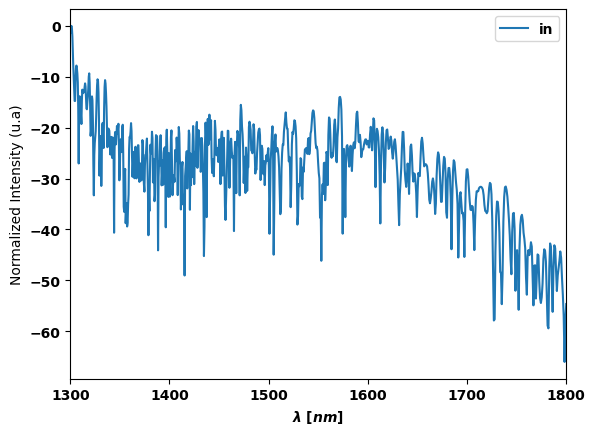

In [46]:
W = V + w0
WL = (2*np.pi*c/W) #iis = (WL>400 & WL<1350); % wavelength grid
N1=1300e-9 ;N2=1800e-9
iis=np.array([(i>N1 and i<N2) for i in WL])

plt.subplot(111)
plt.plot(WL[iis]*1e9,10*np.log10(y),label='in')

plt.xlabel('$\lambda$ $[nm]$')
#plt.title(str(round(z[-1],3))+' [m]')
plt.ylabel('Normalized Intensity (u.a)' )
plt.xlim(1300,1800)
plt.legend()


In [6]:
y0=0
N=2**9
yy=np.linspace(0,1.4,N)
dy=1.4/N
y=y0
for i in range(N):

    y=y+dy*(1+y**2)
    print(y)

print(y)


0.002734375
0.005468770444393157
0.008203227222577224
0.010937786226701465
0.01367248835411271
0.016407374509801988
0.01914248560885204
0.02187786257888602
0.024613546362517717
0.027349577919803567
0.030085998230696825
0.032822848297504155
0.035560169147344986
0.03829800183461394
0.04103638744344662
0.04377536709018914
0.046514981925871626
0.04925527313868606
0.05199628195646878
0.05473804964918795
0.0574806175314363
0.06022402696492949
0.0629683193610104
0.06571353618315963
0.06845971894951271
0.071206909235384
0.07395514867579807
0.07670447896802839
0.07945494187414413
0.08220657922356506
0.08495943291562501
0.08771354492214431
0.09046895729001136
0.09322571214377386
0.09598385168823988
0.09874341821108924
0.10150445408549552
0.10426700177275894
0.10703110382495064
0.10979680288756857
0.11256414170220541
0.11533316310922888
0.11810391005047476
0.12087642557195306
0.12365075282656766
0.1264269350768497
0.12920501569770537
0.13198503817917806
0.13476704612922577
0.13755108327651358
0.1

In [147]:
dy

1.0

In [94]:
a=np.array([1+1j,2,3,4,5])
a[abs(a)>2]=1
a

array([1.+1.j, 2.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])

(436.61243884323557, 1400.0)

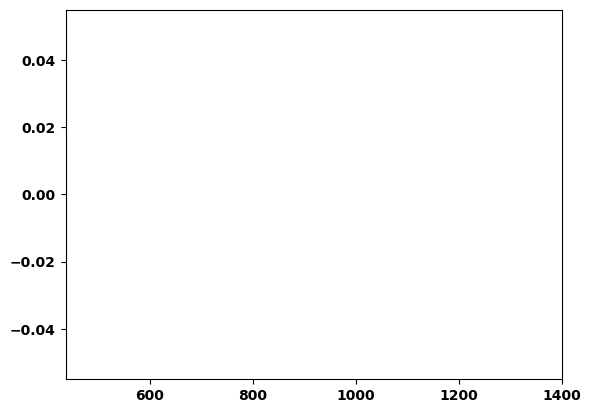

In [139]:
plt.plot(WL*1e9,10*np.log10(abs(y)**2))
plt.xlim(min(WL)*1e9,1400)

In [118]:
abs(y)

array([nan, nan, nan, ..., nan, nan, nan])

In [ ]:
f_minn=1/(2*dT)
V=2*np.pi*np.arange(-f_minn, f_minn,1/(dT*n)) # frequency grid
alpha = np.log(10.**(loss/10))   #attenuation coefficient
B = 0
for i in range(0,len(betas)):      #Taylor expansion of betas
    B = B + betas[i]/math.factorial(i+2)*V**(i+2)
    
L=1j*B - alpha/2

W = V + w0
WL = (2*np.pi*c/W) 
hr=((tau1**2+tau2**2)/(tau1*tau2**2)*np.exp(-TimeGrid/tau2)*np.sin(TimeGrid/tau1))
hr[TimeGrid<0]=0
hr=hr/np.trapz(hr,TimeGrid)
nsaves=10 # Number of points along the distance

z = np.linspace(0,length,nsaves)
deltaz=len(z)/nsaves
C_tilde=np.fft.fftshift(np.fft.ifft(np.fft.fftshift(A)))*TimeWindow
C_tilde=C_tilde.astype('complex')
C=np.fft.fftshift(np.fft.fft(np.fft.fftshift(C_tilde)))/TimeWindow
C_tilde2=np.abs(C)**2
term_1=(1-fr)*C_tilde2
term_2=fr*convft(hr,C_tilde2,TimeWindow)  
M=1j*gamma*W*TimeWindow/w0*np.fft.fftshift(np.fft.ifft(np.fft.fftshift(C*(term_1+term_2))))
final=deltaz*(L*C_tilde+M)

for i in range(len(z)):

    new=np.zeros(len(C_tilde),dtype=complex)
    
    for j in range(0,len(C_tilde)):

        Cij=C_tilde[j]
        Ci_1j=Cij+final[j]
        new[j]=Ci_1j

    C_tilde=new  # Avanza el espectro una posición en el espacio
    C=np.fft.fftshift(np.fft.fft(np.fft.fftshift(C_tilde)))/TimeWindow
    C_tilde2=np.abs(C)**2
    term_1=(1-fr)*C_tilde2
    term_2=fr*convft(hr,C_tilde2,TimeWindow)  
    M=1j*gamma*W*TimeWindow/w0*np.fft.fftshift(np.fft.ifft(np.fft.fftshift(C*(term_1+term_2))))
    final=deltaz*(L*C_tilde+M)

In [7]:
# LIBRERIAS
import matplotlib
from ipywidgets import interact,widgets
import numpy as np
import matplotlib.pylab as plt
import math
from scipy.integrate import solve_ivp
import pandas as pd
from scipy.interpolate import CubicSpline
import seaborn as sns
import os


path=os.getcwd()

def ruido(señal,desv): 
    '''
    Función para añadir ruido Gaussiano dada una desviación estandar

    Parametros
    ----------
    señal: Arreglo
      Arreglo con la señal a la que se le va añadir el ruido
    desv: float
      Desviación estandar
    '''
    señal_ruido=[np.random.normal(señal[i], abs(señal[i]*desv)) for i in range(0,len(señal))]
    return np.array(señal_ruido)
#sns.set_theme()

# Señal sin ruido.

# Pruebas.

In [6]:
c = 299792458;            #speed of light [m/s]

def propagar(desv):
    
    #Constants
    n = 2**13    # number of grid points
    TimeWindow = 12.5e-12 # width of time window [s]     
    dT = TimeWindow/n
    TimeGrid =  np.arange(-n/2,n/2,1)*dT #  time grid
    
    #Laser parameters
    WaveLength=1550e-9      #reference wavelength [m]
    global w0 
    w0 = (2*np.pi*c)/WaveLength  #reference frequency [Hz]
    nu=100e6 #Repetition rate (Hz)
    t0 =200e-15       # duration of input [s]
    power = 80e-3/(nu*t0)        #peak power of input [W]
    A = np.sqrt(power)*1/np.cosh(TimeGrid/(t0/2.634)) # input field [W^(1/2)]

    A=ruido(A,desv)
  
    #Fiber parameters 
    length = 1.0             #ibre length [m]
    D=-1.0*1e-12*1e9*1e-3 #Dispersion
    dD=0.006*1e-12*1e9**2*1e-3  #Dispersion slope
    #betas = [beta2, beta3, ...] in units [s^2/m, s^3/m ...]
    beta2=-WaveLength**2/(2*np.pi*c)*D
    beta3=(WaveLength**2/(2*np.pi*c))**2*(2*D/WaveLength+dD)
    betas=[beta2,beta3]
    gamma = 10.8*1e-3    #nonlinear coefficient [1/W/m]
    loss = 0.1e-3       #loss [dB/m]

    
    #Raman response
    #fr = 0.1929               # fractional Raman contribution
    #tau1 = 9e-15; tau2 = 134e-15;
    #fb=0.21 ; taub=96e-12 

    # Response function modified
    fr=0.490
    tau1=1064*1e-15
    tau2=140*1e-15
    a=11
    b=15
    RT=(a*np.exp(-TimeGrid/tau1)*np.sin(TimeGrid/tau1)
        +b*np.exp(-TimeGrid/tau2)*np.cos(TimeGrid/tau2)) # Response function
      #+fb*(2*taub-TimeGrid)/taub**2*np.exp(-TimeGrid/taub))
    #WN=np.array([0.01060,0.01884,0.04356,0.06828,0.08721,0.09362,0.11518,0.13029,0.14950,0.15728,0.17518,0.20343,0.22886])/1e-15
    #An=np.array([1,11.4,36.67,67.67,74,4.5,6.8,4.6,4.2,4.5,2.7,3.1,5.02])
    
    #gamn=np.array([1.64,3.66,5.49,5.10,4.25,0.77,1.30,4.87,1.87,2.02,4.71,2.86,5.02])*1e-3/1e-15
    #Gamn=np.array([4.91,10.4,16.48,15.3,12.75,2.31,3.91,14.60,5.6,6.06,14.13,8.57,15.07])*1e-3/1e-15


    #RT=[sum(An[i]*np.exp(-gamn[i]*t-Gamn[i]**2*t**2/4)*np.sin(WN[i]*t) for i in range(len(An))) for t in TimeGrid]
    RT=np.array(RT)
    RT[TimeGrid<0]=0
    hr=RT/np.trapz(RT, TimeGrid)
    fw =np.fft.ifft((A))
    global V
    V=2*np.pi*np.arange(-n/2,n/2,1).T/(n*dT)  # frequency grid
    alpha = np.log(10.**(loss/10))   #attenuation coefficient
    B = 0

    for i in range(0,len(betas)):      #Taylor expansion of betas
        B = B + betas[i]/math.factorial(i+2)*V**(i+2)

    L=1j*B - alpha/2
    gamma = gamma/w0   
    W = V + w0  
    HW =np.fft.ifft(np.fft.fftshift(hr.T))*n   # frequency domain Raman
    L=np.fft.fftshift(L) 
    W=np.fft.fftshift(W) 

    #Ecuación a integrar.
    def rhs(z,AW):

        AT=np.fft.fft(np.exp(L*z)*AW) #A TILDE

        IT=np.abs(AT)**2

        AA=np.fft.ifft(IT) #Fourier transform of IT

        RS= fr*np.fft.fft(HW*AA)*dT # Convolution

        M=np.fft.ifft(AT*((1-fr)*IT + RS))  #% response function

        return 1j*gamma*W*M*np.exp(-L*z)

    nsaves=200  # Number of points along the distance

    # Z
    z= np.linspace(0,length,nsaves)

    # solve ODE
    y = solve_ivp(rhs,[min(z),max(z)],fw,t_eval=z)

    for i in range(0,len(y.y[0,:])):
    # change variables, frequency solutions.
        y.y[:,i] = np.fft.fftshift(y.y[:,i]*np.exp(L.T*z[i]))*dT*n 
    
    W = V + w0
    WL = (2*np.pi*c/W) #iis = (WL>400 & WL<1350); % wavelength grid
    N1=1300e-9 ;N2=1800e-9ss
    iis=np.array([(i>N1 and i<N2) for i in WL])
    epsilon1=1e-40
    In1=np.abs(y.y.T[:,iis])**2
    
    return A,In1[-1]/max(In1[-1])

In [27]:
A,y_sruido=propagar(0.0)

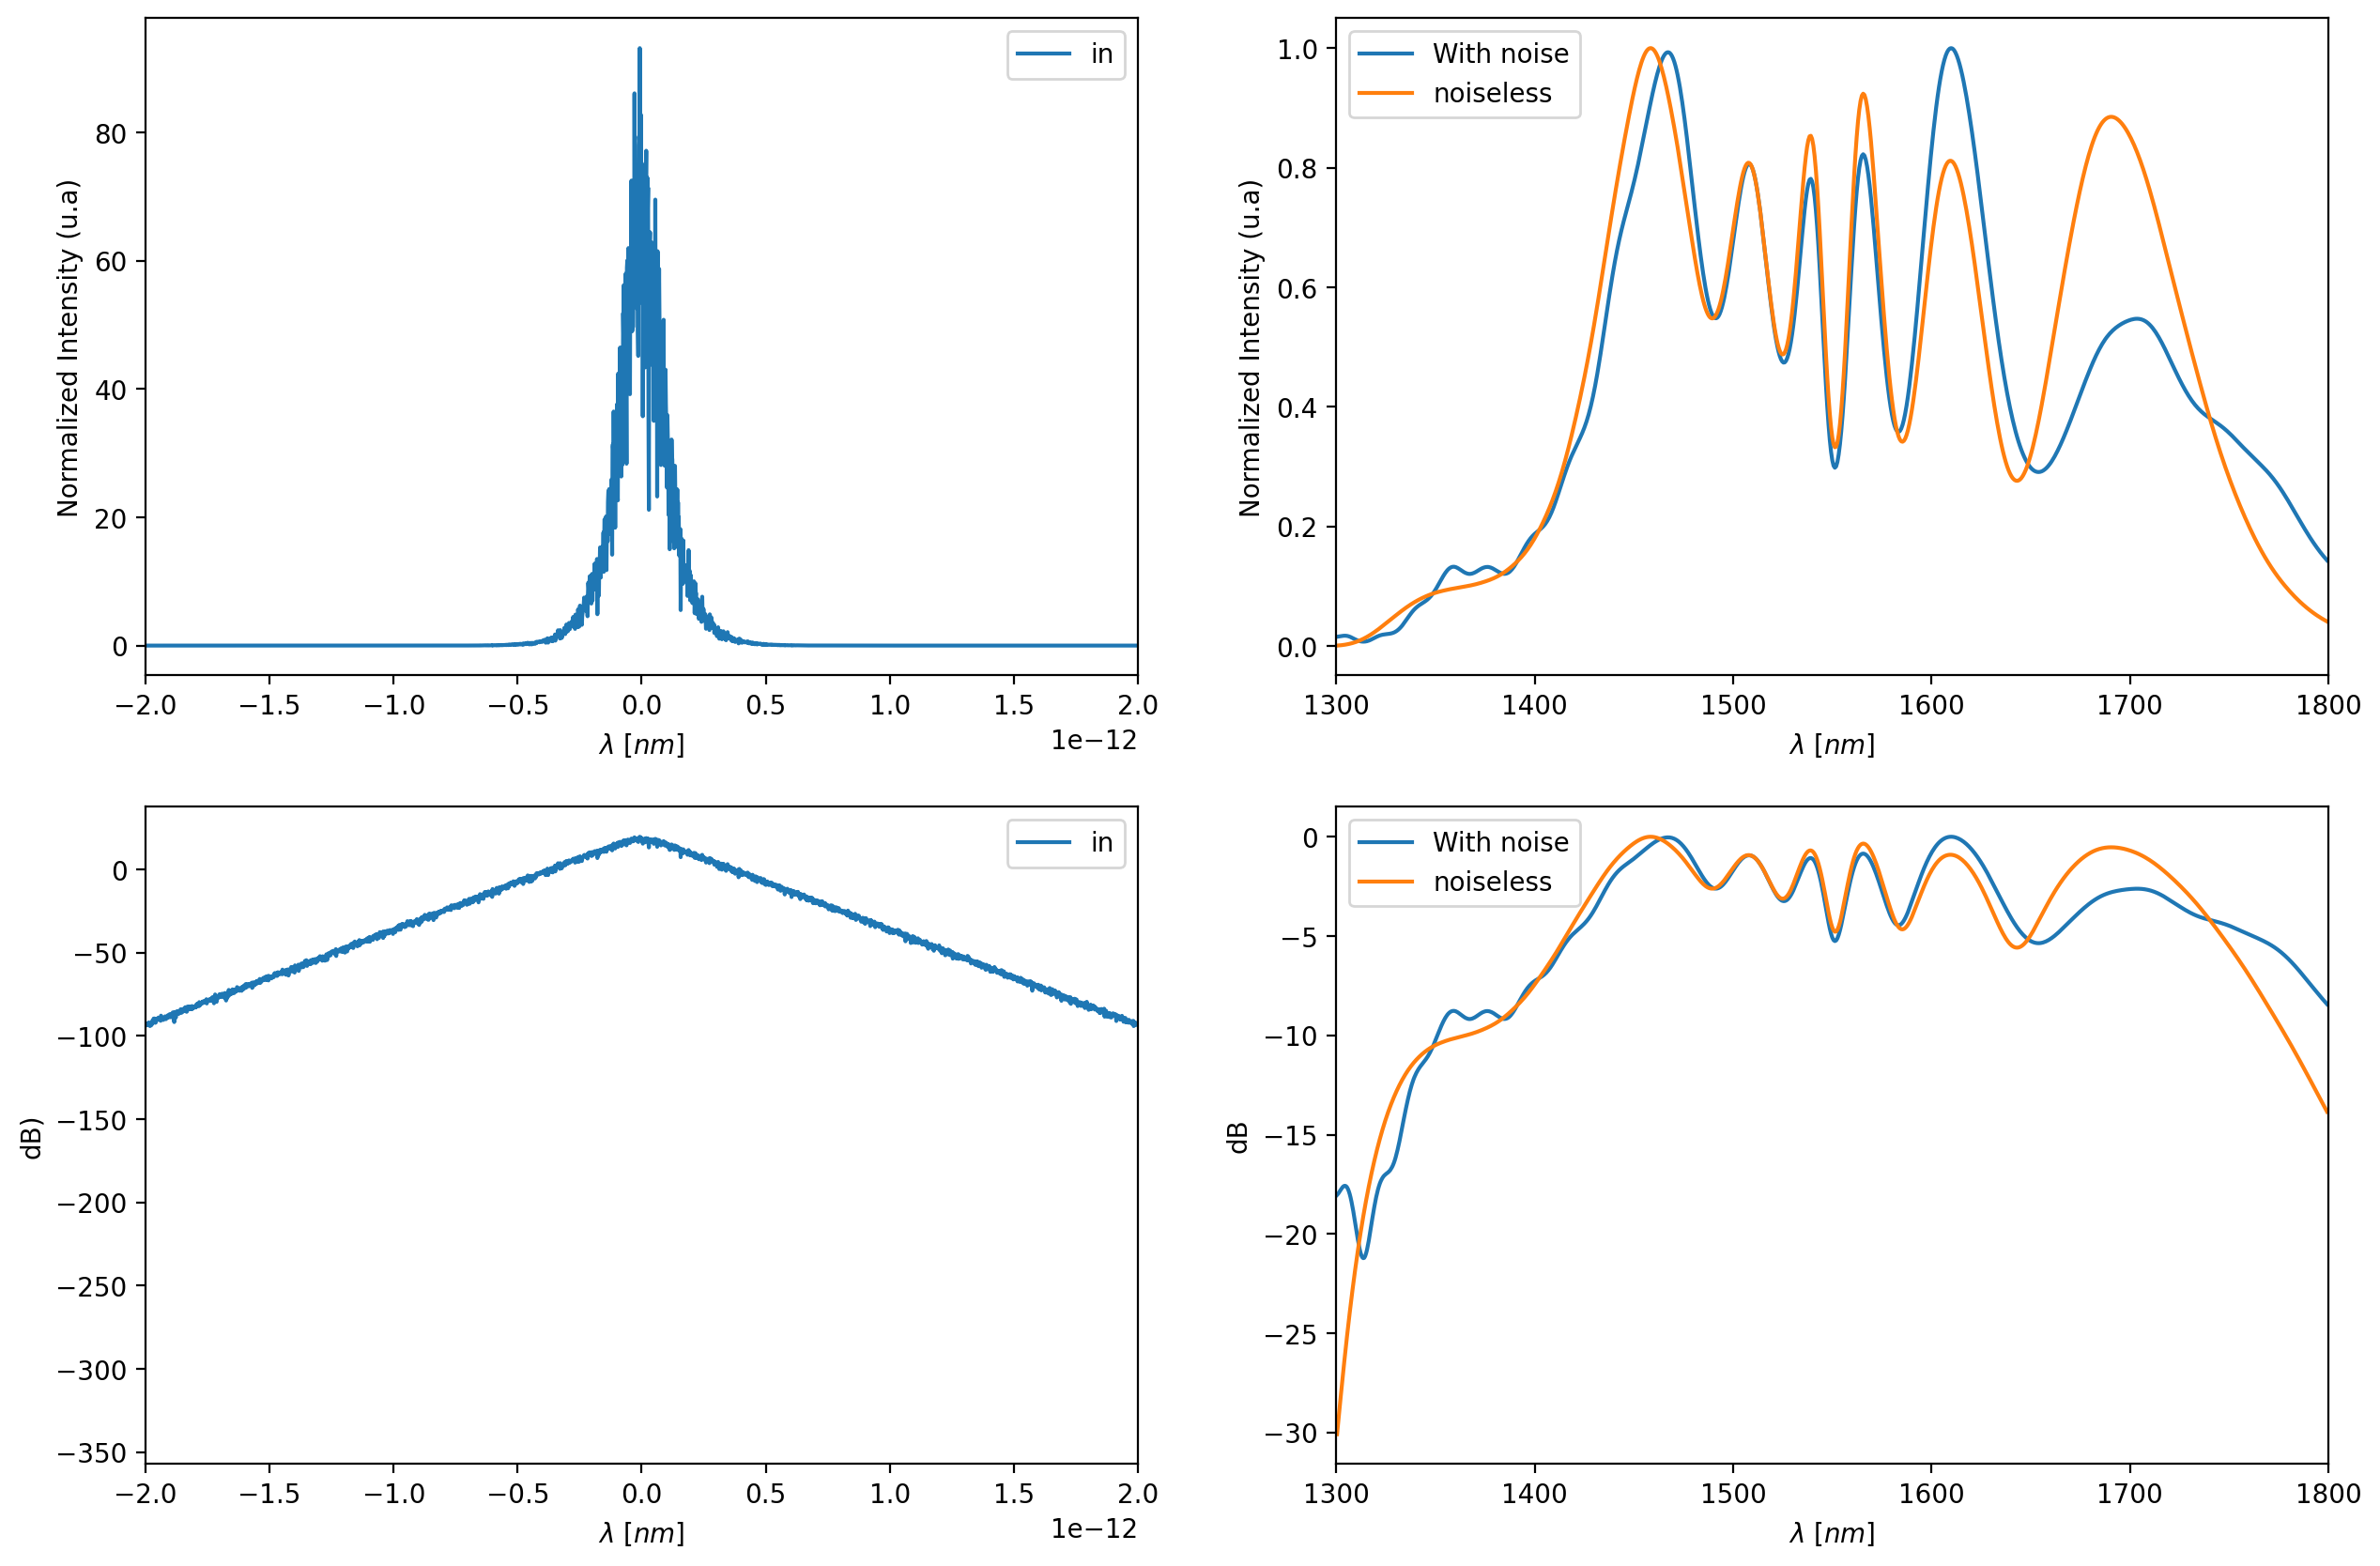

In [42]:
f = plt.figure(figsize=(15, 10),dpi=200)

A,y=propagar(0.2)
W = V + w0
WL = (2*np.pi*c/W) #iis = (WL>400 & WL<1350); % wavelength grid
N1=1300e-9 ;N2=1800e-9
iis=np.array([(i>N1 and i<N2) for i in WL])
n = 2**13    # number of grid points
TimeWindow = 12.5e-12 # width of time window [s]     
dT = TimeWindow/n
TimeGrid =  np.arange(-n/2,n/2,1)*dT #  time grid



plt.subplot(221)

plt.plot(TimeGrid,A,label='in')
plt.xlabel('$\lambda$ $[nm]$')
#plt.title(str(round(z[-1],3))+' [m]')
plt.ylabel('Normalized Intensity (u.a)' )
plt.xlim(-2e-12,2e-12)
plt.legend()


plt.subplot(222)
plt.plot(WL[iis]*1e9,y,label='With noise')
plt.plot(WL[iis]*1e9,y_sruido,label='noiseless')
plt.xlabel('$\lambda$ $[nm]$')
#plt.title(str(round(z[-1],3))+' [m]')
plt.ylabel('Normalized Intensity (u.a)' )
plt.xlim(1300,1800)
plt.legend()

plt.subplot(223)

plt.plot(TimeGrid,10*np.log10(A),label='in')
plt.xlabel('$\lambda$ $[nm]$')
#plt.title(str(round(z[-1],3))+' [m]')
plt.ylabel('dB)' )
plt.xlim(-2e-12,2e-12)
plt.legend()


plt.subplot(224)
plt.plot(WL[iis]*1e9,10*np.log10(y),label='With noise')
plt.plot(WL[iis]*1e9,10*np.log10(y_sruido),label='noiseless')
plt.xlabel('$\lambda$ $[nm]$')
#plt.title(str(round(z[-1],3))+' [m]')
plt.ylabel('dB' )
plt.xlim(1300,1800)
plt.legend()

In [32]:
def anim2(desv):
    f = plt.figure(figsize=(10, 2),dpi=200)
    # plot resultados
    #jojasfjas
    
    A,y=propagar(desv)

    W = V + w0
    WL = (2*np.pi*c/W) #iis = (WL>400 & WL<1350); % wavelength grid
    N1=1300e-9 ;N2=1800e-9
    iis=np.array([(i>N1 and i<N2) for i in WL])


    plt.subplot(121)
    AW=np.fft.fftshift(np.fft.ifft(np.fft.fftshift(A)))
    plt.plot(WL[iis]*1e9,AW[iis],label=desv)
    plt.xlabel('$\lambda$ $[nm]$')
    #plt.title(str(round(z[-1],3))+' [m]')
    plt.ylabel('Normalized Intensity (u.a)' )
    plt.xlim(1300,1800)
    plt.legend()
    
    
    plt.subplot(122)
    plt.plot(WL[iis]*1e9,y,label='With noise')
    plt.plot(WL[iis]*1e9,y_sruido,label='noiseless')
  
    plt.xlabel('$\lambda$ $[nm]$')
    #plt.title(str(round(z[-1],3))+' [m]')
    plt.ylabel('Normalized Intensity (u.a)' )
    plt.xlim(1300,1800)
    plt.legend()

    
    

opc=dict(continuous_update=False,readout_format=".3f")
interact(anim2,       
        desv= widgets.FloatSlider(min=0,max=1,value=0.001,step=0.01,**opc),  
      
        #mm
        );

interactive(children=(FloatSlider(value=0.001, continuous_update=False, description='desv', max=1.0, readout_f…

# Intentando simular situaciones del laboratorio.

In [8]:
paths_amps=[]

for i in range(0,38):
    for j in range(0,50):
        paths_amps.append('MUESTRA_'+str(0)+'_'+str(i)+'_'+str(j)+'.csv')
pulse=np.random.choice(paths_amps)
df = pd.read_csv(path+'/Supercontinuo_1'+'/'+pulse,skiprows=27)
dfA = pd.read_csv(path+'/Pulsos_amp'+'/'+pulse,skiprows=27)


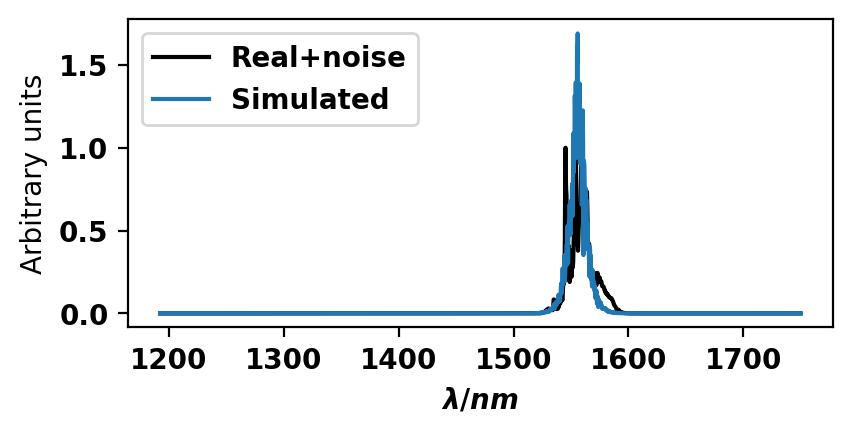

In [9]:
f = plt.figure(figsize=(10, 2),dpi=200)
WL=np.array(df['Stop'][:])  #Wavelengh
WL_central=1556
WL_in=np.linspace(min(WL)-WL_central,max(WL)-WL_central,len(WL))+WL_central
a=1
c=0.3
b=5
l=1
p=5
pulse=a*np.cosh((WL_in-WL_central)/b)**-1+c*np.cosh((WL_in-(WL_central+l))/p)**-1
plt.subplot(121)

plt.plot(dfA['Stop'][:],dfA['1749.9'][:]/max(dfA['1749.9'][:]),'k',label='Real+noise')
plt.plot(WL_in,ruido(pulse,0.2),label='Simulated')
plt.xlabel('$\lambda /nm$')
plt.ylabel('Arbitrary units')
plt.legend()

In [12]:
max(WL)

1749.9

In [12]:
c = 299792458;   
def propagar_lab(a,b,cc,l,p,r,aa,bb,ll):

    
    WL=np.array(df['Stop'][:])  #Wavelengh
    WL_central=1550
    WL_in=np.linspace(min(WL)-WL_central,max(WL)-WL_central,len(WL))+WL_central
    power=(a*np.cosh((WL_in-WL_central)/b)**-1+cc*np.cosh((WL_in-(WL_central+l))/p)**-1
           +aa*np.cosh((WL_in-(WL_central+ll))/bb)**-1)
    power=ruido(power,r)
    wl=WL_central*1e-9
  
    V=np.sort(2*np.pi*c/(1e-9*WL))  #Frequencies.
    midV=(np.max(V)+np.min(V))/2

    V=V - midV# frequency grid

    fw = np.fft.fftshift(power)
    fw=fw.astype('complex')
    n = len(WL)   # number of grid points
    dT = np.pi/V[-1]
    TimeGrid =  np.arange(-n/2,n/2,1)*dT #  time grid
    #Fiber parameters
    length = 2.0             #fibre length [m]
    #betas = [beta2, beta3, ...] in units [s^2/m, s^3/m ...]
    D=-1e-12*1e9*1e-3 #Dispersion
    dD=0.006*1e-12*1e9**2*1e-3  #Dispersion slope
    beta2=-wl**2/(2*np.pi*c)*D
    beta3=(wl**2/(2*np.pi*c))**2*(2*D/wl+dD)
    betas=[beta2,beta3]
    gamma = 10*1e-3    #nonlinear coefficient [1/W/m]
    loss = 0.1e-3       #loss [1/m]
    alpha = np.log(10.**(loss/10))   #attenuation coefficient


    #Raman response
    fr=0.490
    tau1=1064*1e-15
    tau2=140*1e-15
    a=11
    b=15
    RT=(a*np.exp(-TimeGrid/tau1)*np.sin(TimeGrid/tau1)
        +b*np.exp(-TimeGrid/tau2)*np.cos(TimeGrid/tau2)) # Response function
       #+fb*(2*taub-TimeGrid)/taub**2*np.exp(-TimeGrid/taub))# Response function
    RT[TimeGrid<0]=0
    hr=RT/np.trapz(RT, TimeGrid)
    
    B = 0

    for i in range(0,len(betas)):      #Taylor expansion of betas
        B = B + betas[i]/math.factorial(i+2)*V**(i+2)
        
    L=1j*B - alpha/2

    #Laser parameters
    WaveLength=1556e-9      #reference wavelength [m]
    w0 = (2*np.pi*c)/WaveLength  #reference frequency [Hz]

    gamma = gamma/w0   
    W = V +midV
    HW =np.fft.ifft(np.fft.fftshift(hr.T))*n   # frequency domain Raman
    L=np.fft.fftshift(L) 
    W=np.fft.fftshift(W) 

    #Ecuación a integrar.
    def rhs(z,AW):
            
        AT=np.fft.fft(np.exp(L*z)*AW) #A TILDE
        IT=np.abs(AT)**2
        AA=np.fft.ifft(IT) #Fourier transform of IT
        RS= fr*np.fft.fft(HW*AA)*dT # Convolution
        M=np.fft.ifft(AT*((1-fr)*IT + RS))  #% response function
                
        return 1j*gamma*W*M*np.exp(-L*z)

    nsaves=10  # Number of points along the distance

    # Z
    z = np.linspace(0,length,nsaves)
  
    # solve ODE
    y = solve_ivp(rhs,[min(z),max(z)],fw,t_eval=z)

    for i in range(0,len(y.y[0,:])):
       # change variables, frequency solutions.
        y.y[:,i] = np.fft.fftshift(y.y[:,i]*np.exp(L.T*z[i]))*dT*n


    return y,power
   
    




In [13]:
c = 299792458;   
def propagar_lab(p1,r):

    
    WL=np.array(df['Stop'][:])  #Wavelengh
    WL_central=1556
    WL_in=np.linspace(min(WL)-WL_central,max(WL)-WL_central,len(WL))+WL_central
    power=(p1)
    power=ruido(power,r)
    wl=WL_central*1e-9
  
    V=np.sort(2*np.pi*c/(1e-9*WL))  #Frequencies.
    midV=(np.max(V)+np.min(V))/2

    V=V - midV# frequency grid

    fw = np.fft.fftshift(power)
    fw=fw.astype('complex')
    n = len(WL)   # number of grid points
    dT = np.pi/V[-1]
    TimeGrid =  np.arange(-n/2,n/2,1)*dT #  time grid
    #Fiber parameters
    length = 2.0             #fibre length [m]
    #betas = [beta2, beta3, ...] in units [s^2/m, s^3/m ...]
    D=-1e-12*1e9*1e-3 #Dispersion
    dD=0.006*1e-12*1e9**2*1e-3  #Dispersion slope
    beta2=-wl**2/(2*np.pi*c)*D
    beta3=(wl**2/(2*np.pi*c))**2*(2*D/wl+dD)
    betas=[beta2,beta3]
    gamma = 10*1e-3    #nonlinear coefficient [1/W/m]
    loss = 0.1e-3       #loss [1/m]
    alpha = np.log(10.**(loss/10))   #attenuation coefficient


    #Raman response
    fr=0.490
    tau1=1064*1e-15
    tau2=140*1e-15
    a=11
    b=15
    RT=(a*np.exp(-TimeGrid/tau1)*np.sin(TimeGrid/tau1)
        +b*np.exp(-TimeGrid/tau2)*np.cos(TimeGrid/tau2)) # Response function
       #+fb*(2*taub-TimeGrid)/taub**2*np.exp(-TimeGrid/taub))# Response function
    RT[TimeGrid<0]=0
    hr=RT/np.trapz(RT, TimeGrid)
    
    B = 0

    for i in range(0,len(betas)):      #Taylor expansion of betas
        B = B + betas[i]/math.factorial(i+2)*V**(i+2)
        
    L=1j*B - alpha/2

    #Laser parameters
    WaveLength=1556e-9      #reference wavelength [m]
    w0 = (2*np.pi*c)/WaveLength  #reference frequency [Hz]

    gamma = gamma/w0   
    W = V +midV
    HW =np.fft.ifft(np.fft.fftshift(hr.T))*n   # frequency domain Raman
    L=np.fft.fftshift(L) 
    W=np.fft.fftshift(W) 

    #Ecuación a integrar.
    def rhs(z,AW):
            
        AT=np.fft.fft(np.exp(L*z)*AW) #A TILDE
        IT=np.abs(AT)**2
        AA=np.fft.ifft(IT) #Fourier transform of IT
        RS= fr*np.fft.fft(HW*AA)*dT # Convolution
        M=np.fft.ifft(AT*((1-fr)*IT + RS))  #% response function
                
        return 1j*gamma*W*M*np.exp(-L*z)

    nsaves=10  # Number of points along the distance

    # Z
    z = np.linspace(0,length,nsaves)
  
    # solve ODE
    y = solve_ivp(rhs,[min(z),max(z)],fw,t_eval=z)

    for i in range(0,len(y.y[0,:])):
       # change variables, frequency solutions.
        y.y[:,i] = np.fft.fftshift(y.y[:,i]*np.exp(L.T*z[i]))*dT*n


    return y,power
   
    




In [18]:
def anim2(a,b,cc,l,p,r,aa,bb,ll):
    f = plt.figure(figsize=(13, 3),dpi=200)
    # plot resultados
    #jojasfjas

    WL=np.array(df['Stop'][:])  #Wavelengh
    WL_central=1550
    WL_in=np.linspace(min(WL)-WL_central,max(WL)-WL_central,len(WL))+WL_central

    p1=(a*np.cosh((WL_in-WL_central)/b)**-1)+(cc*np.cosh((WL_in-(WL_central+l))/p)**-1
           +aa*np.cosh((WL_in-(WL_central+ll))/bb)**-1)
    
    p2=np.zeros(len(p1))
    
    power=ruido(np.sqrt(p1**2+p2**2),r)
    wl=WL_central*1e-9
    
    y,pulse=propagar_lab(p1,r)
    y1,pulse1=propagar_lab(p2,r)
    In=np.abs(y.y.T[-1]+y1.y.T[-1])**2
    IW1 = 10*np.log10(In)
    
    plt.subplot(121)

    WL=np.array(df['Stop'][:])  #Wavelengh
    WL_central=1556
    WL_in=np.linspace(min(WL)-WL_central,max(WL)-WL_central,len(WL))+WL_central
    
    plt.plot(WL_in,power,'k',label='Input')
    plt.xlabel('$\lambda$ $[nm]$',fontsize=20)
  
    #plt.title(str(round(z[-1],3))+' [m]')
    plt.ylabel('Normalized Intensity (u.a)' )
    plt.xlim(min(WL),max(WL))
    plt.legend()
   
    

 
   
    plt.subplot(122)
    
    plt.plot(WL,10*np.log10(In),label='Supercontinuum')
    plt.xlim(min(WL),max(WL))
    plt.xlabel('$\lambda$ $[nm]$',fontsize=20)
    plt.ylabel('Log scale (a.u)')
    plt.ylim()
    #plt.title(str(round(z[-1],3))+' [m]')
   
  
    plt.legend()
   

opc=dict(continuous_update=False,readout_format=".3f")
interact(anim2,       
        a= widgets.FloatSlider(min=0,max=1,value=0.8,step=0.01,**opc),  
        b= widgets.FloatSlider(min=2,max=20,value=4,step=0.01,**opc),
        cc= widgets.FloatSlider(min=0,max=1,value=0,step=0.01,**opc),  
        l= widgets.FloatSlider(min=-100,max=100,value=-26,step=1,**opc),
        p= widgets.FloatSlider(min=0,max=10,value=3,step=0.01,**opc),
        r= widgets.FloatSlider(min=0,max=1,value=0.1,step=0.01,**opc),
        aa= widgets.FloatSlider(min=0,max=1,value=0,step=0.01,**opc),  
        bb= widgets.FloatSlider(min=0,max=10,value=3,step=0.1,**opc),
        ll= widgets.FloatSlider(min=-100,max=100,value=19,step=5,**opc)
      
          
      
        #mm
        );

interactive(children=(FloatSlider(value=0.8, continuous_update=False, description='a', max=1.0, readout_format…

In [90]:
1556-1575

-19